# Rocks vs Mines Sonar Prediction
By Darshik A S

## 1. Setting Environment

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context("notebook")

## 2. Data Overview

The dataset contains 111 patterns obtained by bouncing sonar signals off a mine and 97 patterns obtained from rocks at various angles and under various conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock.

Each pattern is a set of 60 numbers in the range 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time. The integration aperture for higher frequencies occur later in time, since these frequencies are transmitted later during the chirp.

The label associated with each record contains the letter "R" if the object is a rock and "M" if it is a mine. The numbers in the labels are in increasing order of aspect angle, but they do not encode the angle directly.

In [133]:
# Load dataset
data = pd.read_csv('sonar.all-data.csv',header=None)

In [134]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [135]:
print(data.shape)

(208, 61)


## 3. Data Preparation

In [136]:
# Checking fot null values and datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       208 non-null    float64
 1   1       208 non-null    float64
 2   2       208 non-null    float64
 3   3       208 non-null    float64
 4   4       208 non-null    float64
 5   5       208 non-null    float64
 6   6       208 non-null    float64
 7   7       208 non-null    float64
 8   8       208 non-null    float64
 9   9       208 non-null    float64
 10  10      208 non-null    float64
 11  11      208 non-null    float64
 12  12      208 non-null    float64
 13  13      208 non-null    float64
 14  14      208 non-null    float64
 15  15      208 non-null    float64
 16  16      208 non-null    float64
 17  17      208 non-null    float64
 18  18      208 non-null    float64
 19  19      208 non-null    float64
 20  20      208 non-null    float64
 21  21      208 non-null    float64
 22  22

In [137]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
0,208.0,0.029164,0.022991,0.0015,0.013350,0.02280,0.035550,0.1371
1,208.0,0.038437,0.032960,0.0006,0.016450,0.03080,0.047950,0.2339
2,208.0,0.043832,0.038428,0.0015,0.018950,0.03430,0.057950,0.3059
3,208.0,0.053892,0.046528,0.0058,0.024375,0.04405,0.064500,0.4264
4,208.0,0.075202,0.055552,0.0067,0.038050,0.06250,0.100275,0.4010
5,208.0,0.104570,0.059105,0.0102,0.067025,0.09215,0.134125,0.3823
6,208.0,0.121747,0.061788,0.0033,0.080900,0.10695,0.154000,0.3729
7,208.0,0.134799,0.085152,0.0055,0.080425,0.11210,0.169600,0.4590
8,208.0,0.178003,0.118387,0.0075,0.097025,0.15225,0.233425,0.6828
9,208.0,0.208259,0.134416,0.0113,0.111275,0.18240,0.268700,0.7106


In [138]:
# Class distribution
data.iloc[:,-1].value_counts()

M    111
R     97
Name: 60, dtype: int64

In [139]:
# Replacing R and M with binary values
data.iloc[:,-1].replace({'M':1,'R':0},inplace=True)

## 4. Exploratory data analysis

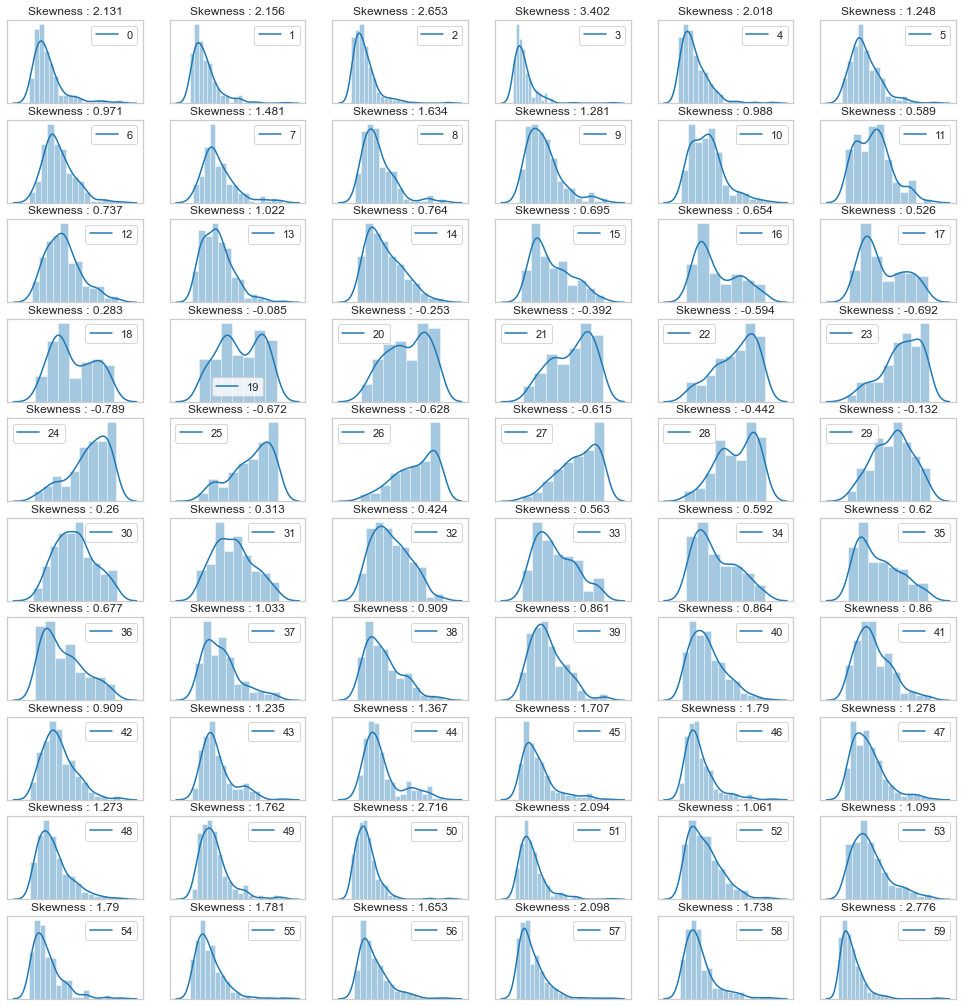

In [140]:
# Distribtuion of signal patterns in each attributes, also with skewness
sk = data.skew()
plt.figure(figsize=(17,18))
for i in range(60):
    ax = plt.subplot(10,6,i+1)
    sns.distplot(data[i],kde_kws={"label": str(i)})
    ax.set_title('Skewness : {}'.format(round(sk[i],3)))
    ax.set_ylabel('')    
    ax.set_xlabel('')
    ax.set_yticks([])    
    ax.set_xticks([])
    ax.legend()
plt.show()

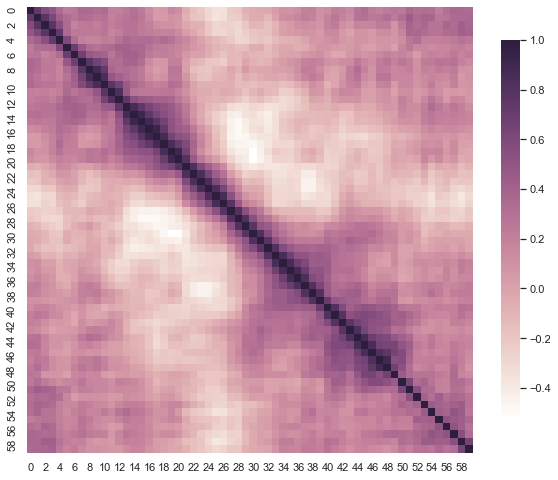

In [13]:
plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(data.iloc[:,:-1].corr(),annot=False,square=True, cmap=cmap, cbar_kws={"shrink": .7})
plt.show()

From the above distribution plot we can see that the distibution of signal patterns are gradually skewed from the right to the left and then to the right along the attributes. Also, from the heatmap the dark purple regions around the diagonal shows the high correlation of the consecutive pairs of attributes. This is beacuse the attributes are in the order of angle measurements from the sensor. 

## 5. Classification

### 5.1 Spliting dataset into train and test data

In [141]:
x = data.iloc[:,0:-1].values.astype(float)
y = data.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=7)

In [142]:
print(x_train.shape)
print(x_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(166, 60)
(42, 60)
1    84
0    82
Name: 60, dtype: int64
1    27
0    15
Name: 60, dtype: int64


### 5.2 Model training and evaluation

In [144]:
# Creating pipelines for input scaling and model training
models = []
models.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
models.append(('LDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
models.append(('KNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
models.append(('DT', Pipeline([('Scaler', StandardScaler()), ('DT',  DecisionTreeClassifier())])))
models.append(('NB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
models.append(('SVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))

In [98]:
# Accuracy for each different K folds
folds = {}
names = []

for name, model in models:
    results = []
    print(name)
    for i in range(2,11):
        kfold = StratifiedKFold(n_splits=i)
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results.mean())
    print('Max Acc is for fold %s: %0.3f' % (str(results.index(max(results))+2),(max(results))))
    folds[name] = results

LR
Max Acc is for fold 3: 0.819
LDA
Max Acc is for fold 10: 0.776
KNN
Max Acc is for fold 10: 0.838
DT
Max Acc is for fold 10: 0.742
NB
Max Acc is for fold 3: 0.686
SVM
Max Acc is for fold 4: 0.855


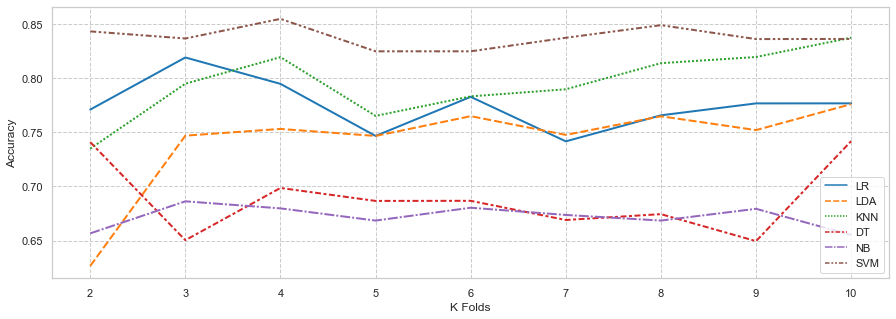

In [99]:
# Plot accuracies for each fold
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=folds,linewidth=2)
ax.set_xticklabels([str(i) for i in range(1,11)])
plt.xlabel('K Folds')
plt.ylabel('Accuracy')
plt.show()

The results shows that the SVM model outperforms rest of the models.

In [100]:
# Creating pipelines for input scaling and ensemble model training
ensemble = []
ensemble.append(('RF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])))
ensemble.append(('AB', Pipeline([('Scaler', StandardScaler()), ('AB', AdaBoostClassifier())])))
ensemble.append(('GBM', Pipeline([('Scaler', StandardScaler()), ('GB', GradientBoostingClassifier())])))
ensemble.append(('ET', Pipeline([('Scaler', StandardScaler()), ('ET', ExtraTreesClassifier())])))

In [101]:
# Accuracy for each different K folds
folds = {}
names = []

for name, model in ensemble:
    results = []
    print(name)
    for i in range(2,11):
        kfold = StratifiedKFold(n_splits=i)
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results.mean())
    print('Max Acc is for fold %s: %0.3f' % (str(results.index(max(results))+2),(max(results))))
    folds[name] = results

RF
Max Acc is for fold 9: 0.849
AB
Max Acc is for fold 10: 0.837
GBM
Max Acc is for fold 8: 0.866
ET
Max Acc is for fold 9: 0.903


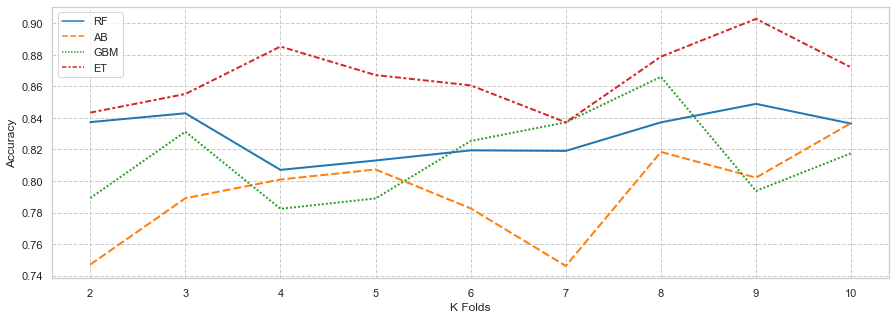

In [102]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=folds,linewidth=2)
ax.set_xticklabels([str(i) for i in range(1,11)])
plt.xlabel('K Folds')
plt.ylabel('Accuracy')
plt.show()

### 5.3 Hyper parameter tuning

In [145]:
scaler = StandardScaler().fit(x_train)
rescaledx = scaler.transform(x_train)

In [114]:
c_values = [0.1,0.3,0.5,0.7,0.9,1.0,1.3,1.5,1.7,2.0]
kernel_values = ['linear', 'poly','rbf','sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = StratifiedKFold(n_splits=4, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result  = grid.fit(rescaledx, y_train)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

Best: 0.866725 using {'C': 2.0, 'kernel': 'rbf'}


In [153]:
max_depth = [1,2,3,4,5]
criteria = ['gini', 'entropy']
param_grid = dict(criterion=criteria, max_depth=max_depth)
model = ExtraTreesClassifier()
kfold = StratifiedKFold(n_splits=9, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result  = grid.fit(rescaledx, y_train)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

Best: 0.836907 using {'criterion': 'entropy', 'max_depth': 5}


## 6. Prediction

In [115]:
model = SVC(C=2.0, kernel='rbf',probability=True)
model.fit(rescaledx, y_train)
rescaled_val_x = scaler.transform(x_test)
preditions = model.predict(rescaled_val_x)
print('Accuracy: ', accuracy_score(y_test, preditions) * 100, '\n')
print('Confusion Matrix : \n',confusion_matrix(y_test, preditions), '\n')
print('Classification Report : \n ',classification_report(y_test, preditions))

Accuracy:  92.85714285714286 

Confusion Matrix : 
 [[14  1]
 [ 2 25]] 

Classification Report : 
                precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.96      0.93      0.94        27

    accuracy                           0.93        42
   macro avg       0.92      0.93      0.92        42
weighted avg       0.93      0.93      0.93        42



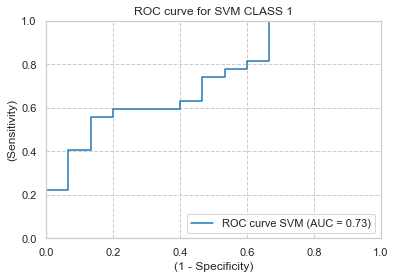

In [116]:
svm_pred_prob = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, svm_pred_prob)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr,label='ROC curve SVM (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.title('ROC curve for SVM CLASS 1')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

In [152]:
scaler  = StandardScaler().fit(x_train)
rescaledx = scaler.transform(x_train)
model = ExtraTreesClassifier(criterion='gini', max_depth=5)
model.fit(rescaledx, y_train)
rescaled_val_x = scaler.transform(x_test)
preditions = model.predict(rescaled_val_x)
print('Accuracy: ', accuracy_score(y_test, preditions) * 100, '\n')
print('Confusion Matrix : \n',confusion_matrix(y_test, preditions), '\n')
print('Classification Report : \n ',classification_report(y_test, preditions))

Accuracy:  85.71428571428571 

Confusion Matrix : 
 [[11  4]
 [ 2 25]] 

Classification Report : 
                precision    recall  f1-score   support

           0       0.85      0.73      0.79        15
           1       0.86      0.93      0.89        27

    accuracy                           0.86        42
   macro avg       0.85      0.83      0.84        42
weighted avg       0.86      0.86      0.85        42



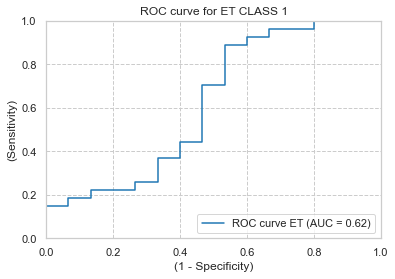

In [122]:
et_pred_prob = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, et_pred_prob)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr,label='ROC curve ET (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.title('ROC curve for ET CLASS 1')
plt.xlabel('(1 - Specificity)')
plt.ylabel('(Sensitivity)')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()